# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_008  Q9BT88                                       15.220
Sample_043  P68104;Q5VTE0                                12.772
Sample_177  Q15084;Q15084-2;Q15084-3;Q15084-4;Q15084-5   14.026
Sample_064  A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339      20.056
Sample_196  D6RF86;P55285;P55285-2                       16.572
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                           
Sample_010  Q8N9I0                                      17.060
Sample_196  E7EU04;F5GZ45;F5H3Z4;F5H4Z6;J3KR13;P14207   15.809
Sample_177  P20338                                      15.493
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.930
            A0A075B6Q5                 13.162
            A0A075B6R2                 12.224
            A0A075B6S5                 14.410
            A0A087WSY4                 13.723
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.019
            Q9UI40;Q9UI40-2            13.845
            Q9UIW2                     13.094
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.355
            Q9UP79                     13.499
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.346,15.050,16.842,19.863,16.053,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.649,19.067,...,15.528,15.576,14.146,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.070,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.440,17.705,17.039,16.060,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.752,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.486,15.345,17.084,18.708,14.249,19.433,11.330,10.994
Sample_207,15.739,16.877,15.469,16.898,14.978,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.930,...,16.012,15.178,13.030,15.050,16.842,19.863,13.546,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.878,19.067,16.188,...,15.528,15.576,12.400,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.654,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.420,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.719,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.476,15.345,17.084,18.708,14.249,19.433,12.888,12.005
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 124.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.49it/s]

100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.25it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.49it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.54it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.64it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.03it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.75it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.70it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.19it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.57it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.12it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.00it/s]

100%|██████████| 7/7 [00:02<00:00,  2.07it/s]

100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.62it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.03it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.04it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.95it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.00it/s]

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.79it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.84it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.60it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.59it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.57it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.27it/s]

100%|██████████| 9/9 [00:02<00:00,  2.79it/s]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.65it/s]

 30%|███       | 3/10 [00:00<00:02,  2.95it/s]

 40%|████      | 4/10 [00:01<00:02,  2.66it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.65it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.67it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.84it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.94it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.94it/s]

100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.15it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.01it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.67it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.55it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.47it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.36it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.76it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.45it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.28it/s]

100%|██████████| 11/11 [00:03<00:00,  2.17it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.93it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.77it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.02it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.21it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.92it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.22it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.05it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.03it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.87it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.03it/s]

100%|██████████| 12/12 [00:04<00:00,  2.13it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.20it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.31it/s]

 31%|███       | 4/13 [00:01<00:04,  1.96it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.86it/s]

 46%|████▌     | 6/13 [00:03<00:03,  1.80it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.04it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.17it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.20it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.23it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.21it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.13it/s]

100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.06it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.87it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.88it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.71it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.62it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.39it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.42it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.34it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.52it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.73it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.82it/s]

100%|██████████| 14/14 [00:05<00:00,  2.91it/s]

100%|██████████| 14/14 [00:05<00:00,  2.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.69it/s]

 20%|██        | 3/15 [00:00<00:03,  3.36it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.02it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.78it/s]

 40%|████      | 6/15 [00:02<00:03,  2.59it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.69it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.83it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.89it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.90it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.94it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.04it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.20it/s]

100%|██████████| 15/15 [00:05<00:00,  3.07it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.067 0.026          0.699 0.394       0.102   
2             0.004 0.003      0.050 0.013          0.763 0.093       0.688   
3             0.004 0.002      0.051 0.015          0.764 0.096       0.685   
4             0.005 0.004      0.059 0.023          0.762 0.099       0.699   
5             0.006 0.004      0.082 0.021          0.747 0.095       0.708   
6             0.005 0.004      0.058 0.026          0.768 0.092       0.741   
7             0.005 0.004      0.053 0.018          0.800 0.082       0.787   
8             0.004 0.003      0.054 0.026          0.811 0.086       0.791   
9             0.007 0.005      0.080 0.023          0.800 0.077       0.782   
10            0.006 0.005      0.075 0.027          0.799 0.084       0.786   
11            0.006 0.005      0.072 0.026          0.801 0.082       0.793   
12            0.005 0.004      0.057 0.024          0.795 0.084       0.789   
13            0.004 0.002      0.046 0.002          0.793 0.082       0.791   
14            0.005 0.004      0.060 0.029          0.791 0.080       0.781   
15            0.007 0.006      0.074 0.024          0.792 0.083       0.778   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.171 0.131                  0.544 0.041        0.844   
2          0.094   0.716 0.061                  0.761 0.047        0.846   
3          0.095   0.716 0.064                  0.761 0.050        0.840   
4          0.089   0.723 0.067                  0.766 0.055        0.844   
5          0.100   0.720 0.063                  0.762 0.050        0.850   
6          0.099   0.749 0.071                  0.786 0.059        0.887   
7          0.093   0.790 0.070                  0.820 0.058        0.903   
8          0.096   0.797 0.073                  0.826 0.061        0.903   
9          0.093   0.788 0.070                  0.819 0.059        0.905   
10         0.097   0.789 0.073                  0.820 0.063        0.905   
11         0.093   0.793 0.069                  0.823 0.059        0.902   
12         0.097   0.789 0.073                  0.819 0.064        0.900   
13         0.095   0.788 0.072                  0.819 0.063        0.899   
14         0.095   0.783 0.071                  0.814 0.062        0.898   
15         0.095   0.782 0.072                  0.813 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.819 0.089        210.000 0.000  
2          0.056                  0.826 0.065        210.000 0.000  
3          0.054                  0.819 0.064        210.000 0.000  
4          0.057                  0.826 0.063        210.000 0.000  
5          0.058                  0.833 0.065        210.000 0.000  
6          0.049                  0.874 0.052        210.000 0.000  
7          0.048                  0.892 0.050        210.000 0.000  
8          0.050                  0.893 0.052        210.000 0.000  
9          0.049                  0.898 0.047        210.000 0.000  
10         0.048                  0.899 0.046        210.000 0.000  
11         0.050                  0.896 0.048        210.000 0.000  
12         0.052                  0.893 0.050        210.000 0.000  
13         0.052                  0.892 0.050        210.000 0.000  
14         0.053                  0.892 0.051        210.000 0.000  
15         0.053                  0.890 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 499.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.62it/s]

100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.03it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.27it/s]

100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.28it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.67it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.70it/s]

100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.29it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.10it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.96it/s]

100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.69it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.13it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.34it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.98it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.89it/s]

100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.70it/s]

 38%|███▊      | 3/8 [00:01<00:02,  1.96it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

100%|██████████| 8/8 [00:03<00:00,  2.29it/s]

100%|██████████| 8/8 [00:03<00:00,  2.21it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.00it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.38it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.27it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.11it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.90it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.93it/s]

100%|██████████| 9/9 [00:02<00:00,  2.66it/s]

100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.95it/s]

 30%|███       | 3/10 [00:00<00:01,  4.11it/s]

 40%|████      | 4/10 [00:01<00:01,  3.36it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.12it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.73it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.76it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.67it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  2.31it/s]

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.34it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.83it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.16it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.02it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.91it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.46it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.13it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.01it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.05it/s]

100%|██████████| 11/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.51it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.25it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.11it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.09it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.12it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.27it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.30it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.13it/s]

100%|██████████| 12/12 [00:05<00:00,  2.08it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.54it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.75it/s]

 31%|███       | 4/13 [00:01<00:03,  2.51it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.63it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.58it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.35it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.33it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.43it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.36it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.40it/s]

100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.17it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.55it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.11it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.70it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.63it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.25it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.19it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.31it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.37it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.48it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.49it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.73it/s]

 20%|██        | 3/15 [00:00<00:03,  3.08it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.97it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.81it/s]

 40%|████      | 6/15 [00:02<00:03,  2.78it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.63it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.81it/s]

 60%|██████    | 9/15 [00:03<00:01,  3.05it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.02it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.99it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.89it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.86it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.77it/s]

100%|██████████| 15/15 [00:05<00:00,  2.66it/s]

100%|██████████| 15/15 [00:05<00:00,  2.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.051 0.015          0.013 0.094       0.002   
2             0.005 0.004      0.075 0.029          0.697 0.115       0.542   
3             0.005 0.004      0.062 0.021          0.748 0.115       0.626   
4             0.005 0.007      0.057 0.020          0.774 0.110       0.619   
5             0.005 0.003      0.064 0.027          0.768 0.086       0.649   
6             0.006 0.005      0.072 0.025          0.782 0.086       0.693   
7             0.004 0.002      0.052 0.019          0.774 0.101       0.756   
8             0.005 0.004      0.060 0.021          0.773 0.097       0.749   
9             0.005 0.004      0.064 0.025          0.768 0.095       0.740   
10            0.006 0.005      0.064 0.025          0.777 0.093       0.771   
11            0.005 0.003      0.056 0.021          0.807 0.094       0.789   
12            0.004 0.000      0.051 0.014          0.805 0.088       0.780   
13            0.004 0.000      0.051 0.015          0.816 0.083       0.784   
14            0.007 0.008      0.066 0.027          0.809 0.086       0.793   
15            0.007 0.006      0.072 0.025          0.808 0.093       0.787   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.017   0.004 0.028                  0.497 0.010        0.864   
2          0.134   0.601 0.110                  0.682 0.076        0.742   
3          0.126   0.672 0.098                  0.732 0.069        0.790   
4          0.119   0.681 0.098                  0.741 0.067        0.806   
5          0.120   0.696 0.086                  0.751 0.060        0.811   
6          0.116   0.728 0.080                  0.774 0.060        0.822   
7          0.113   0.758 0.080                  0.794 0.065        0.887   
8          0.118   0.754 0.081                  0.791 0.065        0.885   
9          0.114   0.747 0.078                  0.786 0.063        0.882   
10         0.119   0.768 0.082                  0.803 0.067        0.886   
11         0.108   0.792 0.076                  0.823 0.063        0.903   
12         0.111   0.786 0.073                  0.819 0.060        0.911   
13         0.104   0.794 0.068                  0.825 0.055        0.913   
14         0.096   0.796 0.067                  0.826 0.056        0.911   
15         0.097   0.793 0.073                  0.823 0.060        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.831 0.087        210.000 0.000  
2          0.077                  0.672 0.097        210.000 0.000  
3          0.074                  0.756 0.091        210.000 0.000  
4          0.071                  0.779 0.087        210.000 0.000  
5          0.068                  0.786 0.085        210.000 0.000  
6          0.074                  0.795 0.089        210.000 0.000  
7          0.051                  0.860 0.063        210.000 0.000  
8          0.052                  0.858 0.063        210.000 0.000  
9          0.054                  0.854 0.066        210.000 0.000  
10         0.051                  0.856 0.064        210.000 0.000  
11         0.047                  0.871 0.062        210.000 0.000  
12         0.043                  0.888 0.051        210.000 0.000  
13         0.042                  0.892 0.049        210.000 0.000  
14         0.043                  0.890 0.050        210.000 0.000  
15         0.043                  0.889 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 926.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 16.90it/s]

100%|██████████| 2/2 [00:00<00:00, 15.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.57it/s]

100%|██████████| 3/3 [00:00<00:00, 21.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.84it/s]

100%|██████████| 4/4 [00:00<00:00, 13.61it/s]

100%|██████████| 4/4 [00:00<00:00, 13.80it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.96it/s]

100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.74it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.94it/s]

100%|██████████| 6/6 [00:00<00:00, 13.91it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 26.42it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 21.25it/s]

100%|██████████| 7/7 [00:00<00:00, 21.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.28it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.03it/s]

100%|██████████| 8/8 [00:00<00:00, 11.92it/s]

100%|██████████| 8/8 [00:00<00:00, 13.12it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 29.97it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 24.72it/s]

100%|██████████| 9/9 [00:00<00:00, 22.20it/s]

100%|██████████| 9/9 [00:00<00:00, 23.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 25.04it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.84it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.41it/s]

100%|██████████| 10/10 [00:00<00:00, 16.89it/s]

100%|██████████| 10/10 [00:00<00:00, 17.76it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.70it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 20.05it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 19.78it/s]

100%|██████████| 11/11 [00:00<00:00, 20.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 29.18it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 25.09it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 23.83it/s]

100%|██████████| 12/12 [00:00<00:00, 23.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 29.43it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.79it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 19.13it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 19.45it/s]

100%|██████████| 13/13 [00:00<00:00, 20.32it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 29.36it/s]

 50%|█████     | 7/14 [00:00<00:00, 25.74it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 24.14it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 23.83it/s]

100%|██████████| 14/14 [00:00<00:00, 24.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 29.38it/s]

 40%|████      | 6/15 [00:00<00:00, 24.48it/s]

 60%|██████    | 9/15 [00:00<00:00, 23.43it/s]

 80%|████████  | 12/15 [00:00<00:00, 23.02it/s]

100%|██████████| 15/15 [00:00<00:00, 23.43it/s]

100%|██████████| 15/15 [00:00<00:00, 23.73it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.070 0.028          0.000 0.000       0.000   
2             0.005 0.004      0.074 0.029          0.590 0.115       0.407   
3             0.007 0.007      0.074 0.031          0.615 0.160       0.382   
4             0.005 0.004      0.061 0.020          0.653 0.100       0.555   
5             0.005 0.005      0.055 0.016          0.647 0.101       0.578   
6             0.004 0.003      0.042 0.010          0.706 0.092       0.641   
7             0.003 0.001      0.040 0.008          0.701 0.089       0.639   
8             0.004 0.002      0.048 0.012          0.704 0.091       0.645   
9             0.003 0.001      0.039 0.007          0.690 0.097       0.627   
10            0.003 0.001      0.036 0.010          0.709 0.092       0.639   
11            0.002 0.001      0.029 0.005          0.709 0.094       0.654   
12            0.003 0.001      0.029 0.005          0.712 0.095       0.658   
13            0.002 0.000      0.029 0.005          0.711 0.098       0.651   
14            0.003 0.001      0.030 0.006          0.711 0.095       0.685   
15            0.003 0.001      0.030 0.006          0.713 0.096       0.655   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.096   0.475 0.087                  0.596 0.063        0.648   
3          0.124   0.459 0.114                  0.598 0.069        0.670   
4          0.092   0.594 0.076                  0.666 0.059        0.769   
5          0.103   0.605 0.084                  0.671 0.068        0.776   
6          0.112   0.664 0.076                  0.720 0.057        0.812   
7          0.096   0.661 0.061                  0.716 0.047        0.812   
8          0.102   0.665 0.066                  0.719 0.052        0.812   
9          0.105   0.649 0.071                  0.706 0.055        0.811   
10         0.099   0.665 0.068                  0.720 0.054        0.811   
11         0.106   0.673 0.070                  0.725 0.056        0.814   
12         0.105   0.677 0.070                  0.728 0.056        0.811   
13         0.115   0.672 0.081                  0.725 0.064        0.811   
14         0.105   0.692 0.078                  0.738 0.064        0.811   
15         0.110   0.677 0.081                  0.729 0.064        0.815   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.687 0.086        210.000 0.000  
2          0.081                  0.617 0.092        210.000 0.000  
3          0.078                  0.619 0.097        210.000 0.000  
4          0.063                  0.708 0.077        210.000 0.000  
5          0.065                  0.721 0.080        210.000 0.000  
6          0.057                  0.741 0.084        210.000 0.000  
7          0.057                  0.737 0.088        210.000 0.000  
8          0.056                  0.737 0.086        210.000 0.000  
9          0.062                  0.736 0.090        210.000 0.000  
10         0.061                  0.737 0.091        210.000 0.000  
11         0.060                  0.745 0.084        210.000 0.000  
12         0.061                  0.741 0.089        210.000 0.000  
13         0.062                  0.740 0.092        210.000 0.000  
14         0.064                  0.735 0.092        210.000 0.000  
15         0.058                  0.746 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,15,3
score_time,5,2,3
test_precision,8,13,15
test_recall,11,14,14
test_f1,8,14,14
test_balanced_accuracy,8,14,14
test_roc_auc,10,13,15
test_average_precision,10,13,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.31it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.03it/s]

 31%|███       | 4/13 [00:00<00:01,  5.31it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.02it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.87it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.76it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.70it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.66it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.95it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.91it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.82it/s]

100%|██████████| 13/13 [00:02<00:00,  4.02it/s]

100%|██████████| 13/13 [00:02<00:00,  4.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 27.11it/s]

 40%|████      | 6/15 [00:00<00:00, 24.23it/s]

 60%|██████    | 9/15 [00:00<00:00, 23.16it/s]

 80%|████████  | 12/15 [00:00<00:00, 23.12it/s]

100%|██████████| 15/15 [00:00<00:00, 22.89it/s]

100%|██████████| 15/15 [00:00<00:00, 23.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.44it/s]

 40%|████      | 4/10 [00:00<00:01,  5.06it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.93it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.74it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.87it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.00it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.08it/s]

100%|██████████| 10/10 [00:01<00:00,  5.16it/s]

100%|██████████| 10/10 [00:01<00:00,  5.18it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


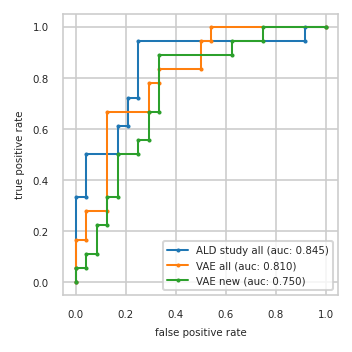

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.333   0.000 0.167   0.042 0.056
3          0.042 0.333   0.042 0.167   0.042 0.111
4          0.042 0.500   0.042 0.278   0.083 0.111
5          0.167 0.500   0.125 0.278   0.083 0.222
6          0.167 0.611   0.125 0.667   0.125 0.222
7          0.208 0.611   0.292 0.667   0.125 0.333
8          0.208 0.722   0.292 0.778   0.167 0.333
9          0.250 0.722   0.333 0.778   0.167 0.500
10         0.250 0.944   0.333 0.833   0.250 0.500
11         0.917 0.944   0.500 0.833   0.250 0.556
12         0.917 1.000   0.500 0.944   0.292 0.556
13         1.000 1.000   0.542 0.944   0.292 0.667
14           NaN   NaN   0.542 1.000   0.333 0.667
15           NaN   NaN   1.000 1.000   0.333 0.889
16           NaN   NaN     NaN   NaN   0.625 0.889
17           NaN   NaN     NaN   NaN   0.625 0.944
18           NaN   NaN     NaN   NaN   0.750 0.944
19           NaN   NaN     NaN   NaN   0.750 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,K7ER15;Q9H0R4;Q9H0R4-2,P51688
2,Q15782;Q15782-6,P02741,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
3,Q9NR34,P61981,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,P07900;P07900-2
5,P61981,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,C9JF17;P05090,P14174,Q96GD0
7,P14174,Q14894,Q9NUQ9
8,Q9Y2T3;Q9Y2T3-3,P63104,O95497


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


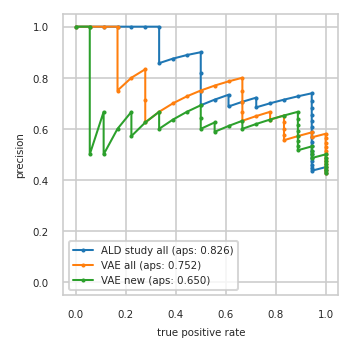

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.571 0.889     0.571 0.889
15         0.630 0.944     0.556 0.833     0.593 0.889
16         0.654 0.944     0.577 0.833     0.615 0.889
17         0.680 0.944     0.600 0.833     0.640 0.889
18         0.708 0.944     0.625 0.833     0.667 0.889
19         0.739 0.944     0.652 0.833     0.652 0.833
20         0.727 0.889     0.636 0.778     0.636 0.778
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.684 0.722     0.632 0.667     0.632 0.667
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.688 0.611     0.750 0.667     0.625 0.556
27         0.733 0.611     0.800 0.667     0.600 0.500
28         0.714 0.556     0.786 0.611     0.643 0.500
29         0.692 0.500     0.769 0.556     0.692 0.500
30         0.750 0.500     0.750 0.500     0.667 0.444
31         0.818 0.500     0.727 0.444     0.636 0.389
32         0.900 0.500     0.700 0.389     0.600 0.333
33         0.889 0.444     0.667 0.333     0.667 0.333
34         0.875 0.389     0.625 0.278     0.625 0.278
35         0.857 0.333     0.714 0.278     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


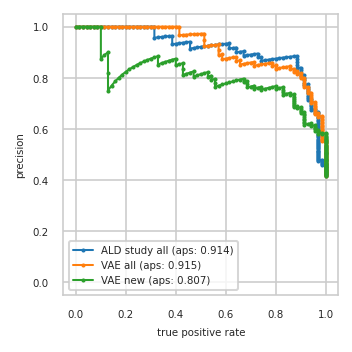

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


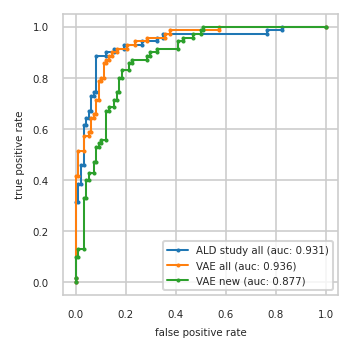

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}